<a href="https://colab.research.google.com/github/rsoto-trinity/Grace/blob/main/GLS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from keras.regularizers import l2

from google.colab import drive
drive.mount('/content/gdrive')

import zipfile
with zipfile.ZipFile('/content/gdrive/MyDrive/archive (2).zip', 'r') as zip_ref:
    zip_ref.extractall('datasetArchive')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:

#path_to_zip = tf.keras.utils.get_file('/content/gdrive/MyDrive/archive (2).zip/ASD_and_NonASD', extract=True)
PATH = '/content/datasetArchive'
#PATH = os.path.join(os.path.dirname(path_to_dataset), 'ASD_and_NonASD')
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'valid')
test_dir = os.path.join(PATH, 'test')

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2536 files belonging to 2 classes.
Found 100 files belonging to 2 classes.


Data augmentation and preprocessing

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
validation_dataset = validation_dataset.skip(val_batches // 5)
class_names = train_dataset.class_names

Found 300 files belonging to 2 classes.


In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.5),
])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Create a base model: Choose one of the existing/trained models

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=(160,160,3),
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
# 80 images, since our batch_size is 80
#print(feature_batch.shape)

Add classification layers:



In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
dense1 = tf.keras.layers.Dense(128,activation = 'relu', kernel_regularizer = l2(0.015))
fa = dense1(feature_batch_average)
prediction_layer = tf.keras.layers.Dropout(0.4)
prediction_layer = tf.keras.layers.Dense(2, activation = 'softmax')
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(fa)

Chain all layers together

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = dense1(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

Set all other parameters:

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

Train and evaluate

In [ ]:
initial_epochs = 35
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/35
80/80 [==============================] - 32s 107ms/step - loss: 3.7808 - accuracy: 0.6360 - val_loss: 3.3643 - val_accuracy: 0.6200
Epoch 2/35
80/80 [==============================] - 8s 98ms/step - loss: 2.9848 - accuracy: 0.7248 - val_loss: 2.8094 - val_accuracy: 0.6900
Epoch 3/35
80/80 [==============================] - 8s 96ms/step - loss: 2.3621 - accuracy: 0.7650 - val_loss: 2.0920 - val_accuracy: 0.7600
Epoch 4/35
80/80 [==============================] - 7s 91ms/step - loss: 1.8855 - accuracy: 0.7855 - val_loss: 2.1720 - val_accuracy: 0.5600
Epoch 5/35
80/80 [==============================] - 8s 100ms/step - loss: 1.5505 - accuracy: 0.7772 - val_loss: 1.3638 - val_accuracy: 0.8300
Epoch 6/35
80/80 [==============================] - 7s 92ms/step - loss: 1.2645 - accuracy: 0.7890 - val_loss: 1.1327 - val_accuracy: 0.8300
Epoch 7/35
80/80 [==============================] - 8s 100ms/step - loss: 1.0359 - accuracy: 0.8151 - val_loss: 1.0243 - val_accuracy: 0.7700
Epoch 8/3

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = next(iter(test_dataset))

test_loss, test_acc = model.evaluate(image_batch,  label_batch, verbose=2, batch_size=300)
print(test_acc)


1/1 - 0s - loss: 0.5611 - accuracy: 0.8750 - 55ms/epoch - 55ms/step
0.875


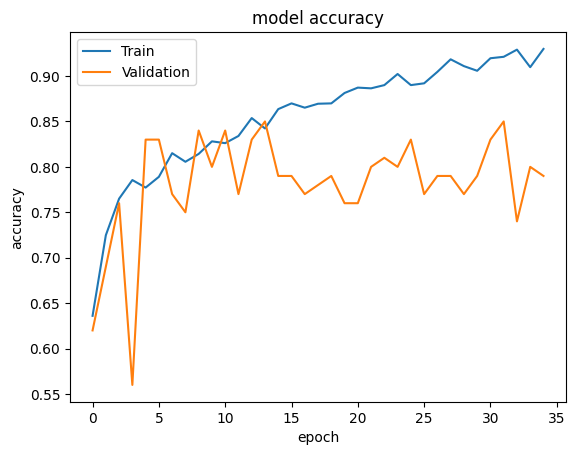

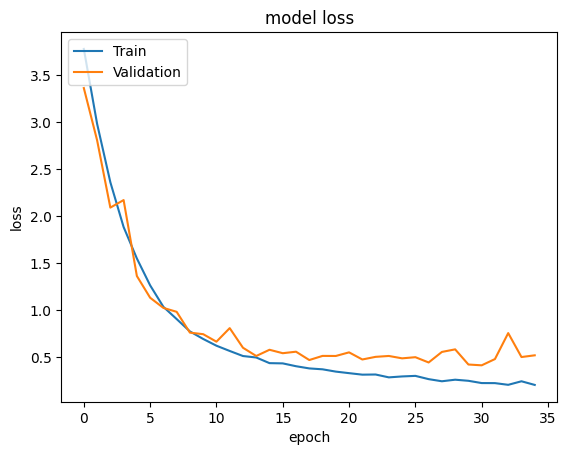

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
